# Imports

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50 


# Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteS8VBN1/horses_or_humans-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteS8VBN1/horses_or_humans-test.tfrecord*...:   …

Dataset horses_or_humans downloaded and prepared to ~/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


,image,label
0,,0 (horses)
1,,0 (horses)
2,,0 (horses)
3,,0 (horses)

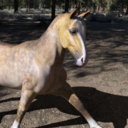
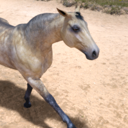
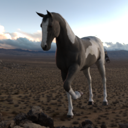
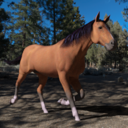

In [2]:
splits, info=ds=tfds.load('horses_or_humans', as_supervised=True, with_info=True,split=['train[:80%]', 'train[80%:]', 'test'])

(train, validation, test)=splits

num_classes=info.features['label'].num_classes

tfds.as_dataframe(train.take(4), info)


In [3]:
@tf.function
def data_preprocess(image, label):
    
    image=tf.image.resize(image, (224, 224))
    image=image / 255.0
    return image, label

train_ds=train.map(data_preprocess).batch(32)
validation_ds=validation.map(data_preprocess).batch(32)
test_ds=test.map(data_preprocess).batch(32)


# Model

In [4]:
resnet50='https://tfhub.dev/tensorflow/resnet_50/feature_vector/1?tf-hub-format=compressed'

model = tf.keras.Sequential([
    hub.KerasLayer(resnet50, input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


# Custom_Train_Gragh

In [5]:
train_loss=SparseCategoricalCrossentropy()
validation_loss=SparseCategoricalCrossentropy()

train_accuracy=SparseCategoricalAccuracy()
validation_accuracy=SparseCategoricalAccuracy()
                               
optimizer=Adam()

In [6]:
@tf.function
def train_one_step(model, x, y, train_loss, train_accuracy ,optimizer):
    
    with tf.GradientTape() as tape:
        
        y_pred = model(x)
        loss = train_loss(y, y_pred)
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_accuracy(y, y_pred)
    return loss


In [12]:
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):

    step = 0
    loss = 0.0
    for epoch in range(epochs):
        
        for x, y in train_ds:

            step += 1
            with tf.device(device_name=device):
        
                loss = train_one_step(model, x, y, train_loss, train_accuracy, optimizer)
            
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            
            for x, y in valid_ds:
        
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())
    
       

In [13]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS=2
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, validation_ds, validation_loss, validation_accuracy)


Step 1 : train loss 0.00162926596 ; train accuracy 0.967469871
Step 2 : train loss 0.00140095293 ; train accuracy 0.967780411
Step 3 : train loss 0.0061956076 ; train accuracy 0.96808511
Step 4 : train loss 0.00302440301 ; train accuracy 0.968384087
Step 5 : train loss 0.00383631978 ; train accuracy 0.968677521
Step 6 : train loss 0.00271745888 ; train accuracy 0.96896553
Step 7 : train loss 0.00270649558 ; train accuracy 0.969248295
Step 8 : train loss 0.00201602047 ; train accuracy 0.969525933
Step 9 : train loss 0.00156235264 ; train accuracy 0.969798684
Step 10 : train loss 0.00325080846 ; train accuracy 0.970066547
Step 11 : train loss 0.00245437073 ; train accuracy 0.970329642
Step 12 : train loss 0.00290127099 ; train accuracy 0.970588207
Step 13 : train loss 0.00267253886 ; train accuracy 0.970842361
Step 14 : train loss 0.00298180431 ; train accuracy 0.971092105
Step 15 : train loss 0.00299456576 ; train accuracy 0.971337557
Step 16 : train loss 0.00168170838 ; train accuracy 

# Evaluation

In [118]:
y_predict=[]
y_test=[]

for images, labels in test_ds:
  pred=model(images)
  pred=pred.numpy()
  pred=np.argmax(pred, axis=1)
  y_predict.extend(labels.numpy())
  y_test.extend(labels.numpy())
  
print(y_test)
print(y_predict)  
false_predicts=np.where([y_test[i] != y_predict[i] for i in range(len(y_test))])
print("num_false_predictions:",false_predicts[0].shape)


[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,